# Yardstick Example

This example notebook provides a simple example of how you can use the Yardstick benchmark to collect performance metrics from Minecraft-like games and how to evaluate their performance.

## Running an experiment

The cell below shows you how to run a simple experiment.

In [69]:
from yardstick_benchmark.provisioning import Das
from yardstick_benchmark.monitoring import Telegraf
from yardstick_benchmark.games.minecraft.server import PaperMC
from yardstick_benchmark.games.minecraft.workload import WalkAround
import yardstick_benchmark
from time import sleep
from datetime import datetime
from pathlib import Path
import os

if __name__ == "__main__":

    ### DEPLOYMENT ENVIRONMENT ###

    # The DAS compute cluster is a medium-sized cluster for research and education.
    # We use it in this example to provision bare-metal machines to run our performance
    # evaluation.
    das = Das()
    # We reserve 2 nodes.
    nodes = das.provision(num=2)

    try:
        # Just in case, we remove data that may have been left from a previous run.
        yardstick_benchmark.clean(nodes)

        ### METRICS ###

        # # Telegraf (https://www.influxdata.com/time-series-platform/telegraf/)
        # # is the metric collection tool we use to collect performance metrics from the
        # # nodes and any applications deployed on these nodes.
        # telegraf = Telegraf(nodes)
        # # We plan to deploy our Minecraft-like game server on node 0.
        # # To obtain application level metrics from the game server,
        # # the next two lines configure node 0 to run additional metric collection
        # # tools.
        # telegraf.add_input_jolokia_agent(nodes[0])
        # telegraf.add_input_execd_minecraft_ticks(nodes[0])
        # # Perform the actual deployment of Telegraf.
        # # This includes downloading the Telegraf executable and preparing configuration
        # # files.
        # res = telegraf.deploy()
        # # Start Telegraf on all remote nodes.
        # telegraf.start()

        ### System Under Test (SUT) ###

        # PaperMC (https://papermc.io/) is the Minecraft-like game whose performance
        # we'll evaluate in this example.
        # We pass a list with all the nodes on which we want to deploy a server.
        # In this example, we only deploy a server on node 0.
        papermc = PaperMC(nodes[:1])
        # We perform the deployment, including downloading the game executable JAR and
        # correctly configuring the game's configuration file.
        papermc.deploy()
        # We start the game server.
        papermc.start()

        ### WORKLOAD ###

        wl = WalkAround(nodes[1:], nodes[0].host)
        wl.deploy()
        wl.start()

        sleep_time = 10
        print(f"sleeping for {sleep_time} seconds")
        sleep(sleep_time)

        papermc.stop()
        papermc.cleanup()

        # telegraf.stop()
        # telegraf.cleanup()

        timestamp = (
            datetime.now()
            .isoformat(timespec="minutes")
            .replace("-", "")
            .replace(":", "")
        )
        dest = Path(f"/var/scratch/{os.getlogin()}/yardstick/{timestamp}")
        yardstick_benchmark.fetch(dest, nodes)
    finally:
        yardstick_benchmark.clean(nodes)
        das.release(nodes)


14642.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



PLAY [Clean data from nodes] ***************************************************

TASK [Gathering Facts] *********************************************************


14658.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Loading Result Data

In [26]:
import pandas as pd

metrics_file = Path(f"/var/scratch/{os.getlogin()}/yardstick/20240621T0027/node016/telegraf-ig2uu7rq/metrics-node016.csv")

keys = {}
with open(metrics_file) as fin:
    for line in fin:
        first_delim = line.find(",")
        second_delim = line.find(",", first_delim+1)
        key = line[first_delim+1:second_delim]
        if key not in keys:
            keys[key] = open(metrics_file.parent / f"{key}.csv", "w+")
        keys[key].write(line)
for key, fd in keys.items():
    fd.close()

## Visualizing Results

<Axes: xlabel='Time [m]', ylabel='CPU utilization [%]'>

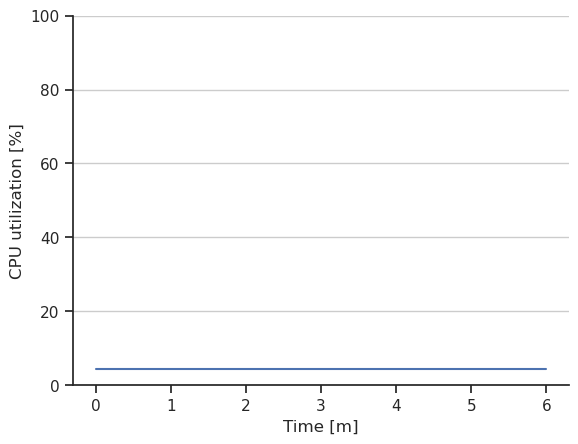

In [67]:
import seaborn as sns

df = pd.read_csv(metrics_file.parent / "cpu.csv", names = ["timestamp","measurement","core_id","cpu","host","physical_id","time_active","time_guest","time_guest_nice","time_idle","time_iowait","time_irq","time_nice","time_softirq","time_steal","time_system","time_user"])
df["timestamp"] = df["timestamp"].transform(lambda x: x - x.min())
df["timestamp_m"] = df["timestamp"] / 60
df = df[df.cpu == "cpu-total"]
df['time_total'] = df.time_active + df.time_idle
df['util'] = 100 * df.time_active / df.time_total
df = df[df.groupby(["timestamp", "cpu"])["time_total"].rank(ascending=False) <= 1]
df.head()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.lineplot(df, x="timestamp_m", y="util")
ax.grid(axis="y")
ax.set_ylim(bottom=0, top=100)
ax.set_ylabel("CPU utilization [%]")
ax.set_xlabel("Time [m]")
ax



<Axes: xlabel='Time [m]', ylabel='Tick duration [ms]'>

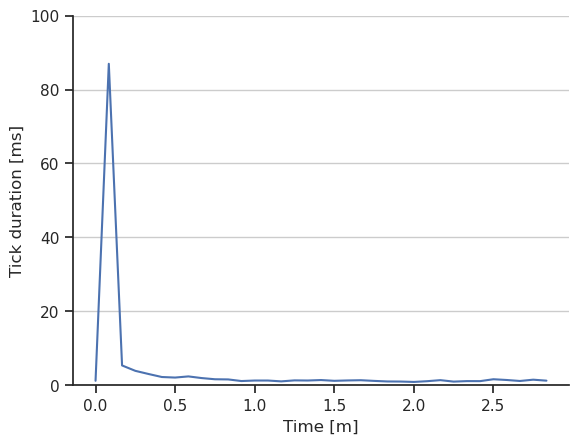

In [ ]:
# timestamp,measurement,cpu,host,usage_guest,usage_guest_nice,usage_idle,usage_iowait,usage_irq,usage_nice,usage_softirq,usage_steal,usage_system,usage_user
df = pd.read_csv(metrics_file.parent / "minecraft_tick_times.csv", names = ["timestamp", "label", "node", "jolokia_endpoint", "tick_duration_ms"])
df["timestamp"] = df["timestamp"].transform(lambda x: x - x.min())
df["timestamp_m"] = df["timestamp"] / 60
df.head()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.lineplot(df, x="timestamp_m", y="tick_duration_ms")
ax.grid(axis="y")
ax.set_ylim(bottom=0)
ax.set_ylabel("Tick duration [ms]")
ax.set_xlabel("Time [m]")
ax